In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import datetime as dt
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM,  GRU, Bidirectional
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error

In [18]:
# đọc dữ liệu từ các file csv
stockList = ["FPT", "MSN", "PNJ", "VIC"]
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("data/" + i + ".csv")

In [21]:
# định dạng cấu trúc thời gian
for i in stockList:
    df_[i]['Date/Time'] = pd.to_datetime(df_[i]['Date/Time'])
    print(df_[i].head())

  Ticker           Date/Time   Open   High    Low  Close  Volume  \
0    FPT 2018-12-25 09:15:00  30.89  30.89  30.89  30.89   35410   
1    FPT 2018-12-25 09:16:00  30.81  30.81  30.81  30.81     190   
2    FPT 2018-12-25 09:17:00  30.74  30.81  30.74  30.74    1120   
3    FPT 2018-12-25 09:18:00  30.74  30.74  30.74  30.74    2120   
4    FPT 2018-12-25 09:19:00  30.74  30.74  30.74  30.74   22500   

   Open Interest  
0              0  
1              0  
2              0  
3              0  
4              0  
  Ticker           Date/Time  Open  High   Low  Close  Volume  Open Interest
0    MSN 2017-12-25 09:15:00  73.1  73.1  73.1   73.1    4210              0
1    MSN 2017-12-25 09:16:00  73.0  73.0  73.0   73.0    5000              0
2    MSN 2017-12-25 09:18:00  73.5  73.5  73.5   73.5     210              0
3    MSN 2017-12-25 09:20:00  73.2  73.5  73.1   73.1    2050              0
4    MSN 2017-12-25 09:21:00  73.0  73.0  73.0   73.0    1380              0
  Ticker       

In [35]:
# tạo dataFrame cho giá đóng cửa

data_close_ = {}
for i in stockList:
    data_close_[i] = pd.DataFrame(df_[i],columns=['Date/Time','Close'])
    data_close_[i].index=df_[i]['Date/Time']
    data_close_[i].drop('Date/Time',axis=1,inplace=True)
    print('\n-----------'+i+'-----------')
    print(data_close_[i])


-----------FPT-----------
                     Close
Date/Time                 
2018-12-25 09:15:00  30.89
2018-12-25 09:16:00  30.81
2018-12-25 09:17:00  30.74
2018-12-25 09:18:00  30.74
2018-12-25 09:19:00  30.74
...                    ...
2020-12-22 14:24:00  58.20
2020-12-22 14:25:00  58.20
2020-12-22 14:26:00  58.20
2020-12-22 14:29:00  58.10
2020-12-22 14:46:00  58.10

[97406 rows x 1 columns]

-----------MSN-----------
                     Close
Date/Time                 
2017-12-25 09:15:00   73.1
2017-12-25 09:16:00   73.0
2017-12-25 09:18:00   73.5
2017-12-25 09:20:00   73.1
2017-12-25 09:21:00   73.0
...                    ...
2020-12-22 14:23:00   82.8
2020-12-22 14:24:00   82.8
2020-12-22 14:25:00   82.8
2020-12-22 14:27:00   82.8
2020-12-22 14:46:00   82.8

[135354 rows x 1 columns]

-----------PNJ-----------
                     Close
Date/Time                 
2018-02-28 09:15:00  78.99
2018-02-28 09:16:00  78.94
2018-02-28 09:19:00  78.14
2018-02-28 09:20:00  78.14
20

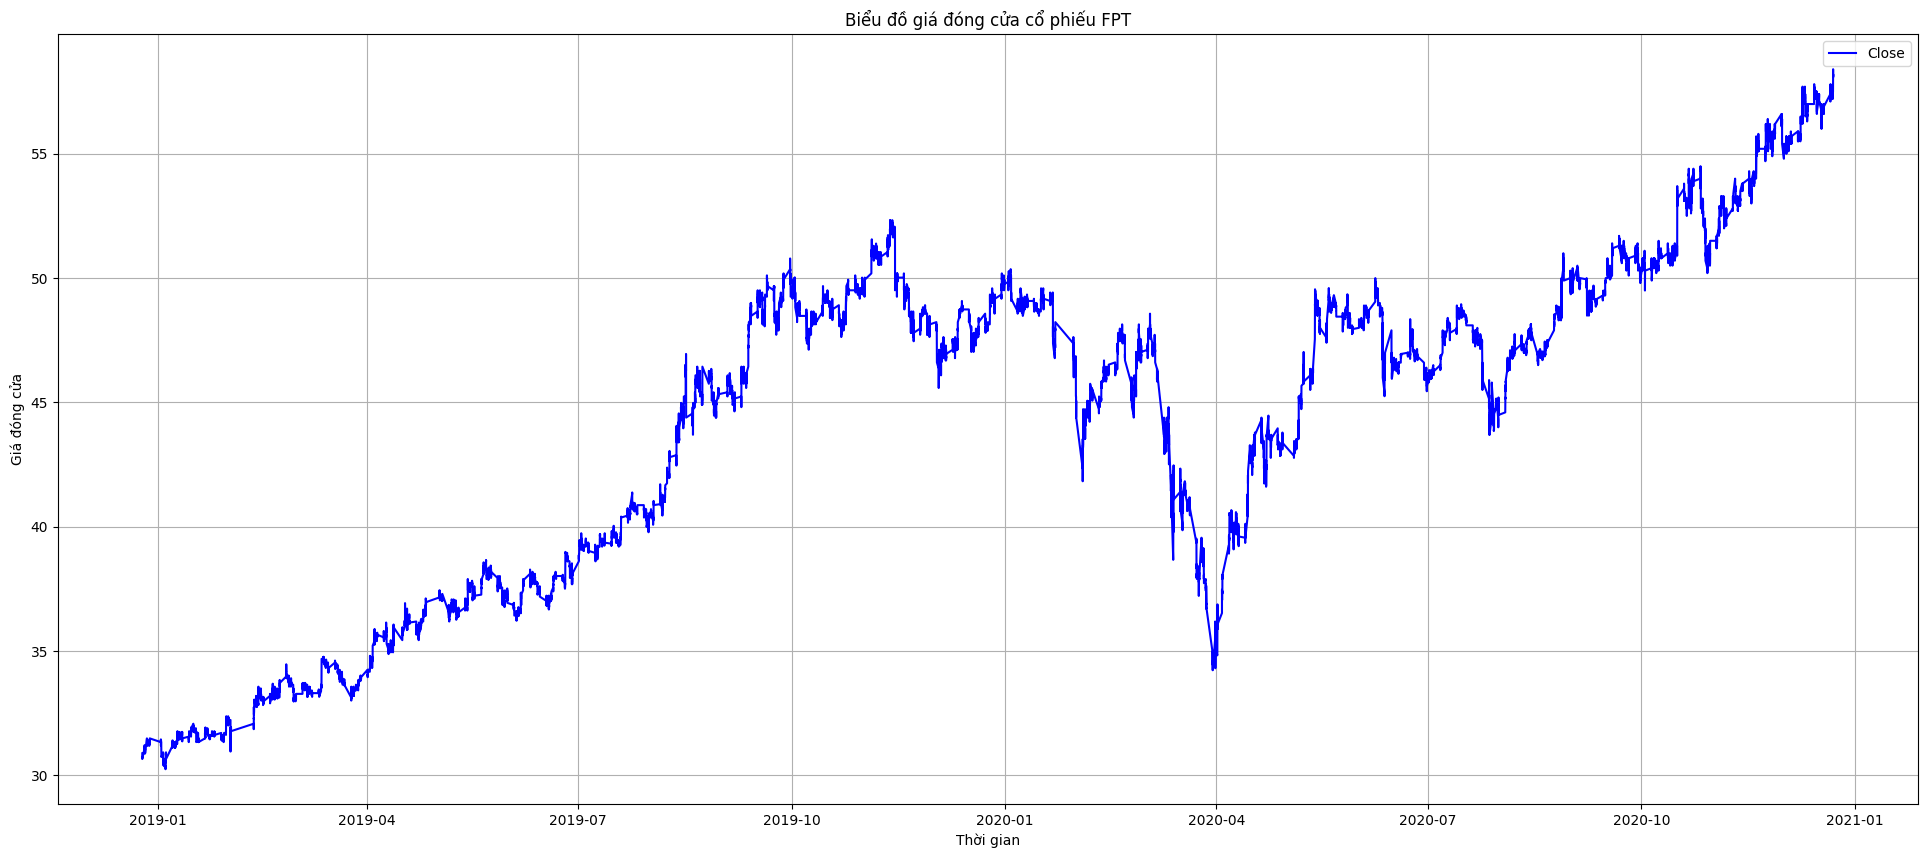

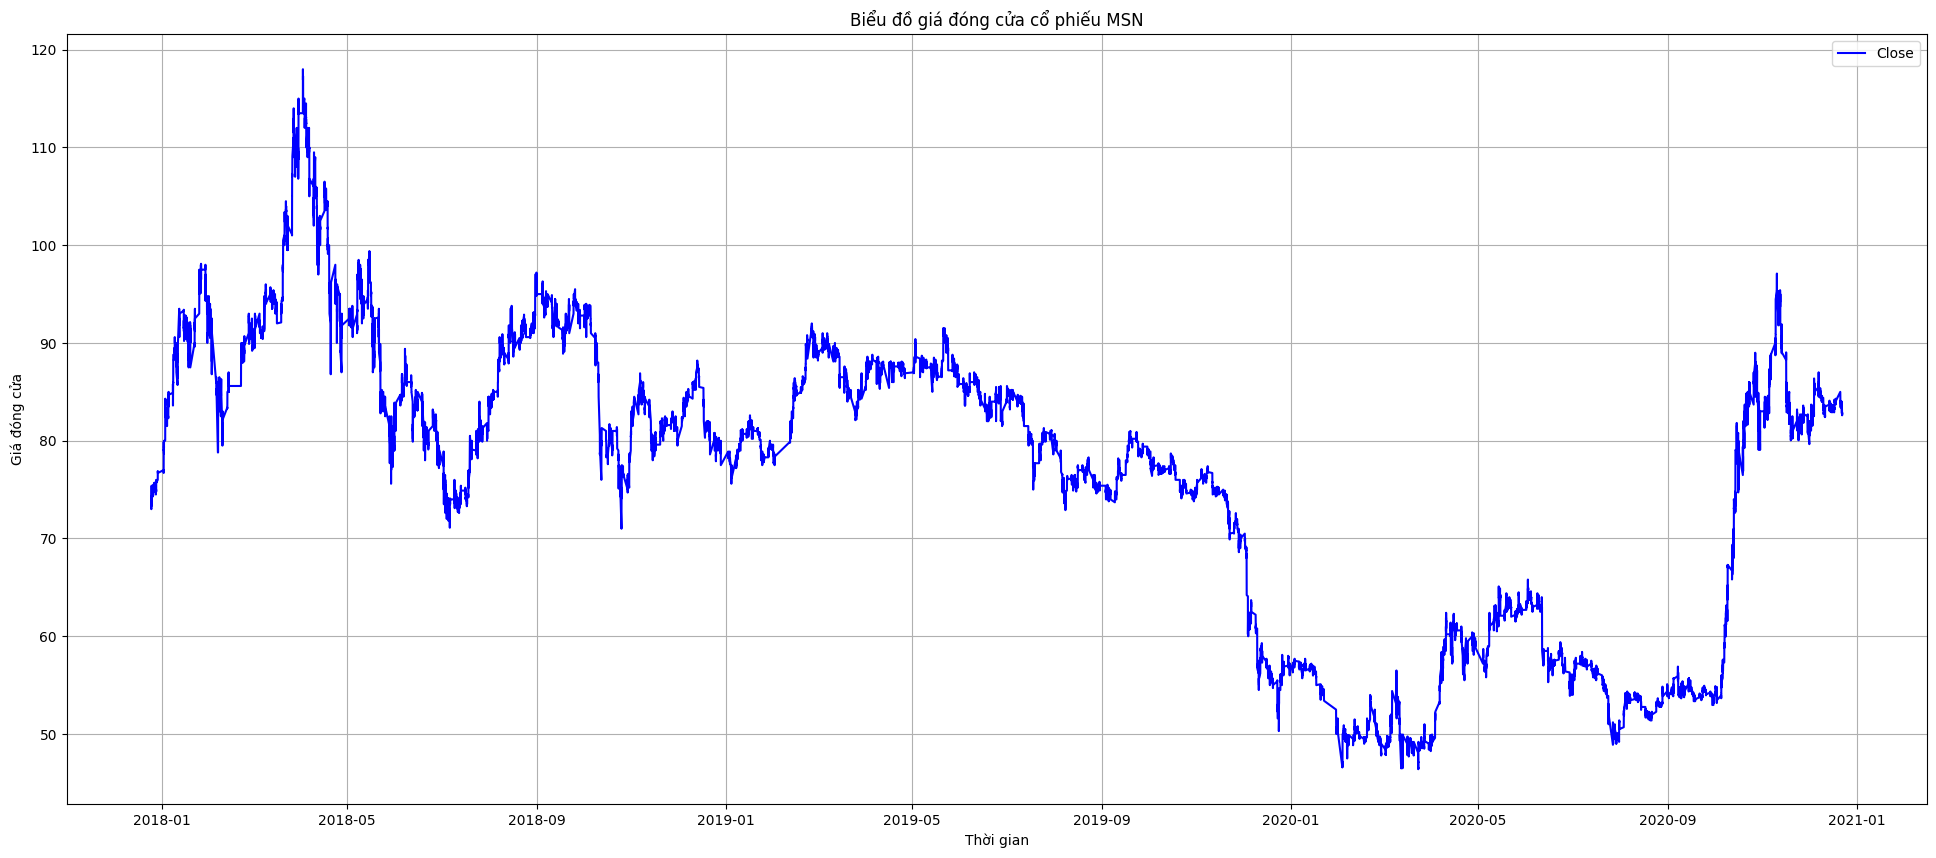

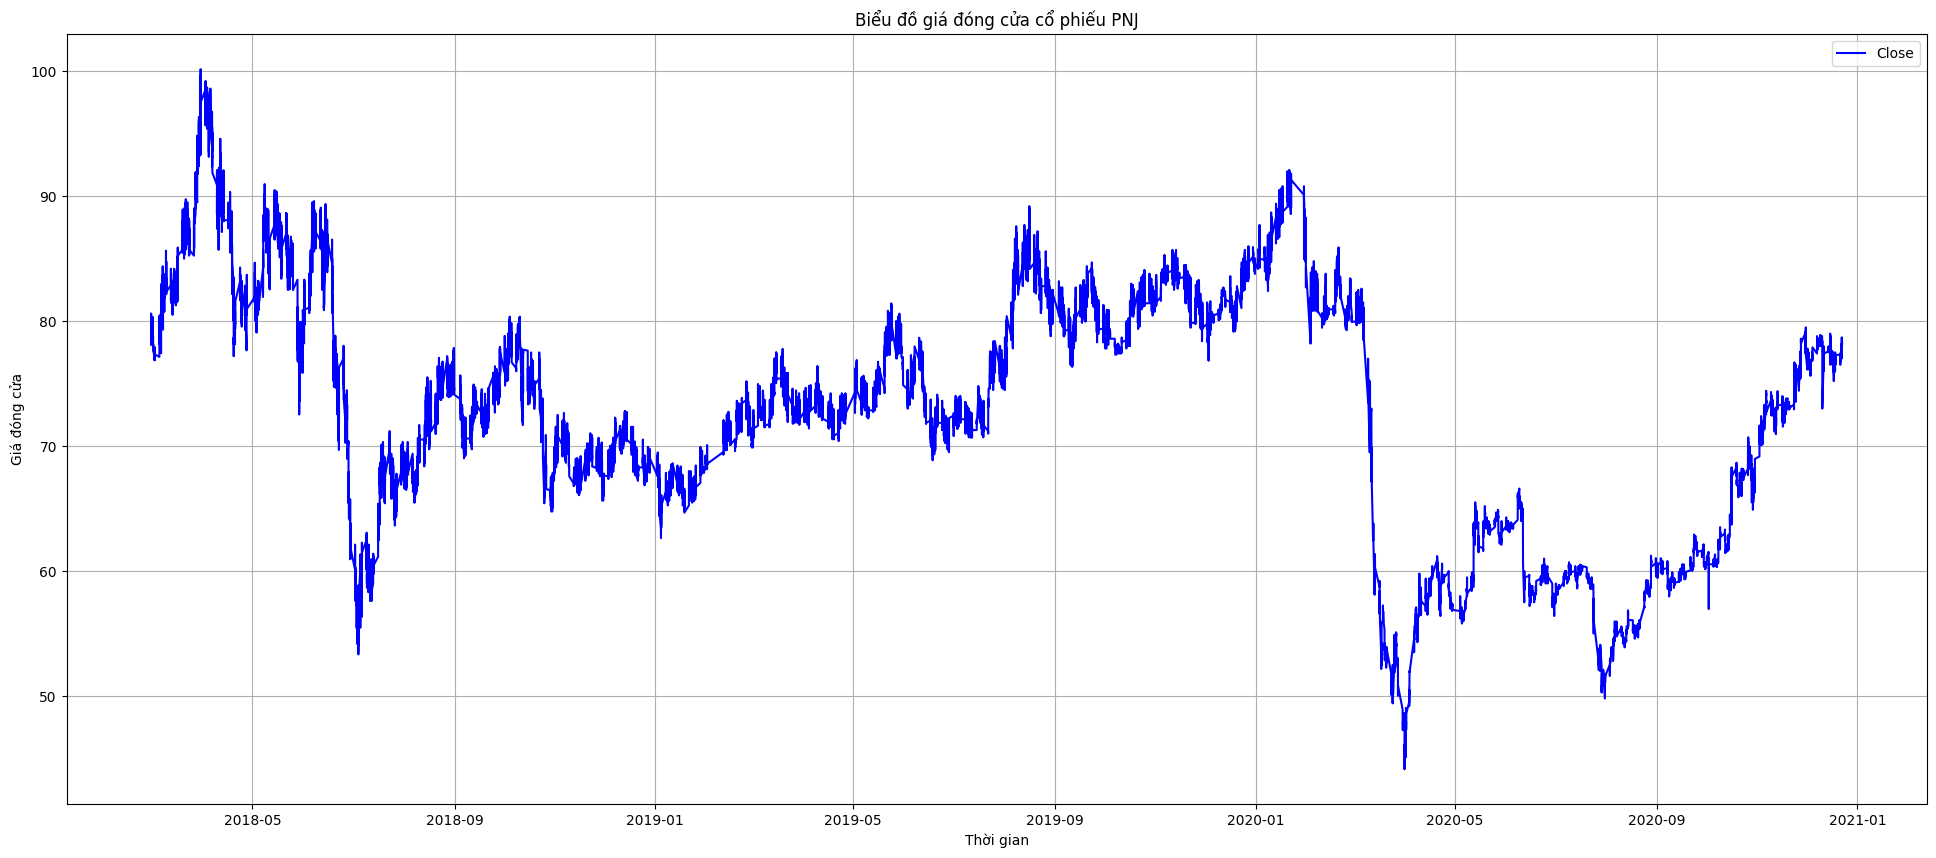

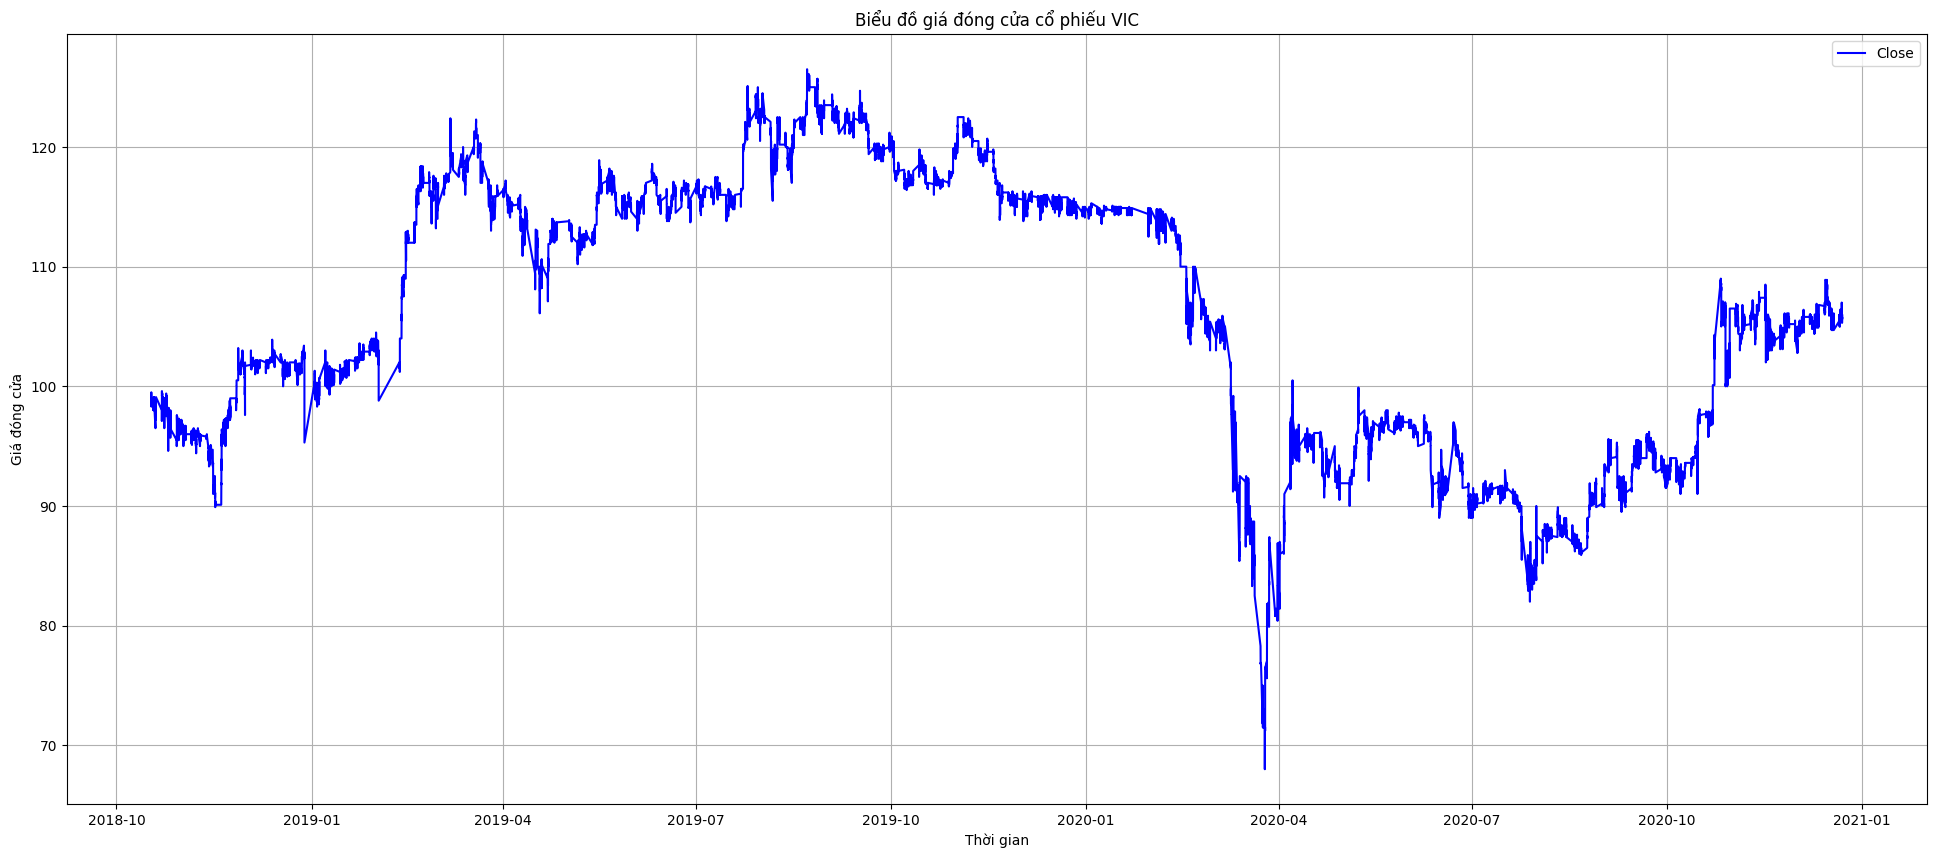

In [37]:
# vẽ biểu đồ đường cho cột 'Close'
for i in stockList:
    plt.figure(figsize=(24, 10))
    plt.plot(data_close_[i]['Close'], label='Close', color='blue')
    plt.title('Biểu đồ giá đóng cửa cổ phiếu '+i)
    plt.xlabel('Thời gian')
    plt.ylabel('Giá đóng cửa')
    plt.legend()
    plt.grid(True)
    plt.show()

In [149]:
data_close_arr_ = {}
scaled_data_ = {}
trainset = {}

scaler_ = {}

for i in stockList:
    # chuyển dataFrame thành numpy array
    data_close_arr_[i] = data_close_[i].values
    
    # split data thành train và test set
    split = int(0.8*len(data_close_arr_[i]))
    train, test = data_close_arr_[i][:split], data_close_arr_[i][split:]

    # chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data_[i] = scaler.fit_transform(data_close_arr_[i])
    scaler_[i] = scaler
   
    # tạo cấu trúc dữ liệu training với 60 time-steps và 1 output
    X_train, y_train = [], []
    for j in range(60,len(train)):
        X_train.append(scaled_data_[i][j-60:j,0])
        y_train.append(scaled_data_[i][j,0])
    
    # Chuyển X_train và y_train thành numpy arrays cho mô hình LSTM training 
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Chuyển dạng dữ liệu thành 3D theo định dạng yêu cầu của LSTM (samples, time steps, features)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    trainset[i] = {}
    trainset[i]["X"] = X_train
    trainset[i]["y"] = y_train

In [44]:
# Tạo và fit mạng LSTM 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
for i in stockList:
    print("Fitting to", i)
    model.fit(trainset[i]["X"], trainset[i]["y"], epochs=100, batch_size=200)

Fitting to FPT
Epoch 1/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - loss: 0.0111
Epoch 2/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0014
Epoch 3/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0011
Epoch 4/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 9.2248e-04
Epoch 5/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 7.6874e-04
Epoch 6/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 6.1585e-04
Epoch 7/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 4.8934e-04
Epoch 8/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 3.9381e-04
Epoch 9/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 3.4530e-04
Epoch 10/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 3.0515e-04
Epoch 11/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 2.7796e-04
Epoch 12/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 2.6858e-04
Epoch 13/100
390/390 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - loss: 2.5675e-04
Epoch 14/100
390/390 ━━━━━━━━━━

In [167]:
pre_closing_price_ = {}
for i in stockList:
    
    split = int(0.8*len(data_close_arr_[i]))
    test = data_close_arr_[i][split:]
    inputs = data_close_arr_[i] [len(data_close_arr_[i]) - len(test) - 60:]
    inputs = inputs.reshape(-1,1)
    inputs  = scaler_[i].transform(inputs)

    # Tạo test data set
    X_test = []
    for j in range(60,inputs.shape[0]):
        X_test.append(inputs[j-60:j,0])

    # Chuyển data thành numpy array
    X_test = np.array(X_test)

    # Chuyển data thành 3-D
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    # Xử dụng mô hình đã huấn luyện để dự đoán
    pre_closing_price_[i] = model.predict(X_test)
    pre_closing_price_[i] = scaler_[i].inverse_transform(pre_closing_price_[i]) 

609/609 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
846/846 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
784/784 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
633/633 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [170]:

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

C:\Users\admin\AppData\Local\Temp\ipykernel_19432\4193392405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = pre_closing_price_[i]


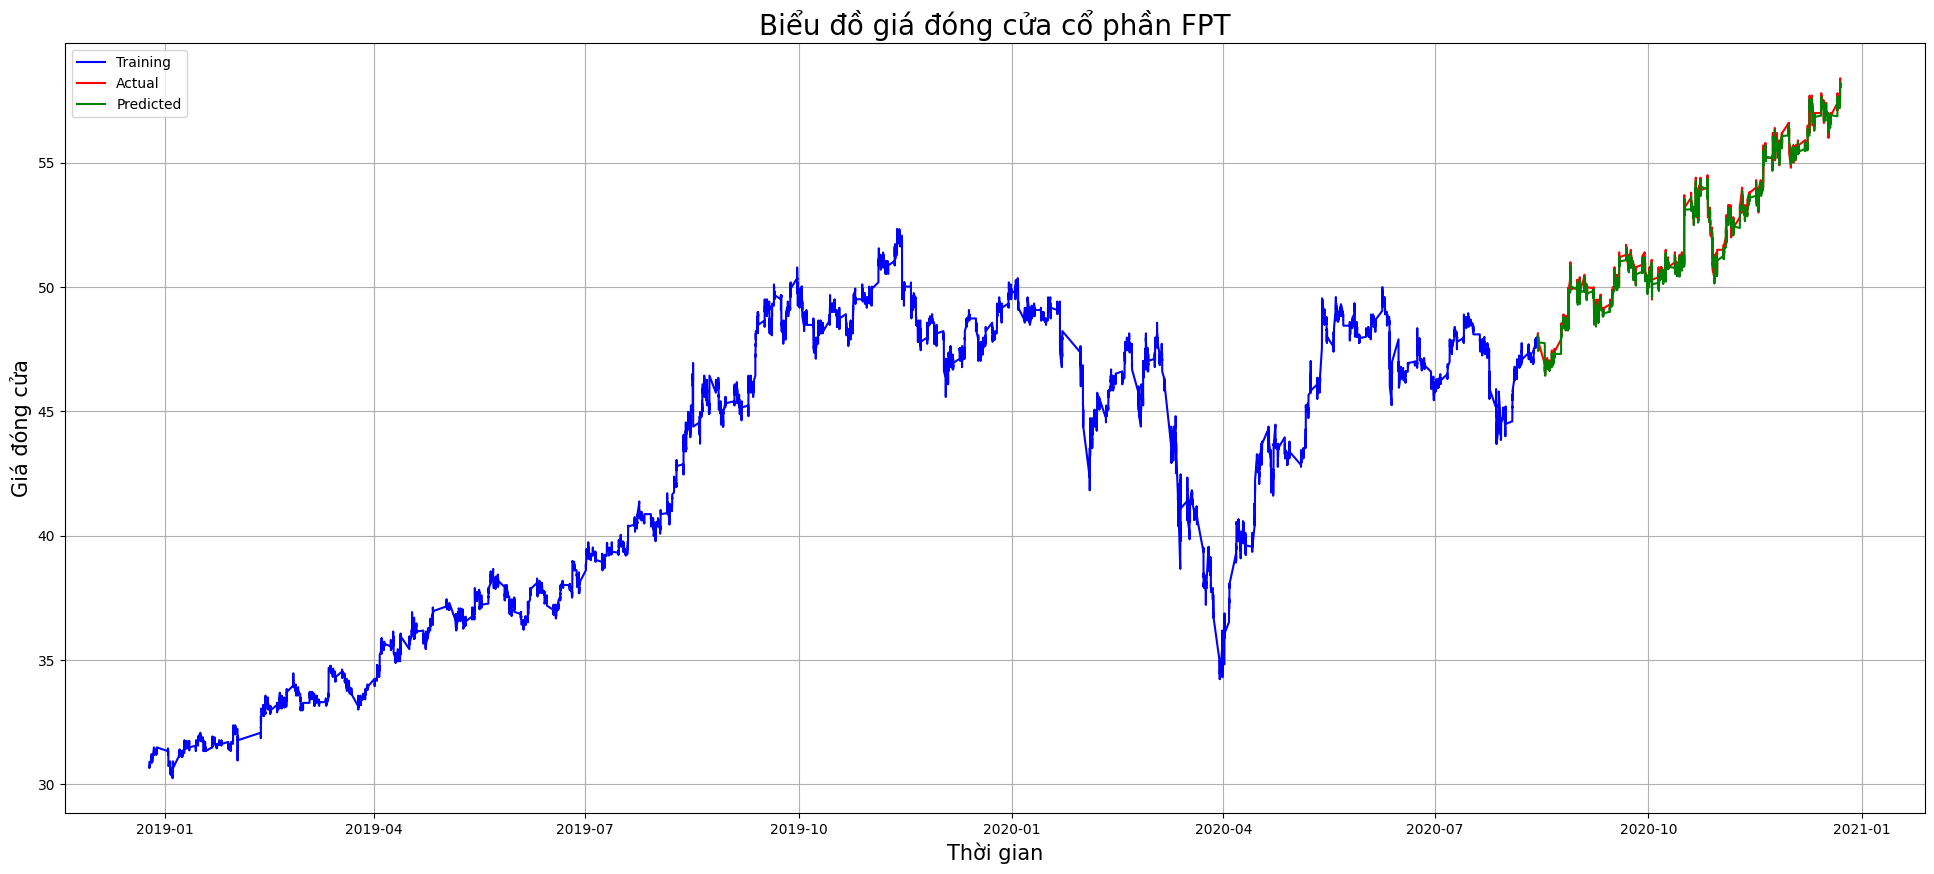

độ phù hợp tập test 0.9987870091934475
sai số tuyệt đối trung bình tập test:  0.08255342754320545
phần trăm sai số truyệt đối trung bình:  0.0015896651525143005
                     Close  Prediction
Date/Time                             
2020-08-14 09:33:00  48.10   47.902699
2020-08-14 09:34:00  48.10   47.967487
2020-08-14 09:35:00  48.10   47.997841
2020-08-14 09:36:00  48.10   48.006310
2020-08-14 09:37:00  48.15   48.007862
...                    ...         ...
2020-12-22 14:24:00  58.20   58.057831
2020-12-22 14:25:00  58.20   58.081757
2020-12-22 14:26:00  58.20   58.090477
2020-12-22 14:29:00  58.10   58.095558
2020-12-22 14:46:00  58.10   58.051521

[19482 rows x 2 columns]


C:\Users\admin\AppData\Local\Temp\ipykernel_19432\4193392405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = pre_closing_price_[i]


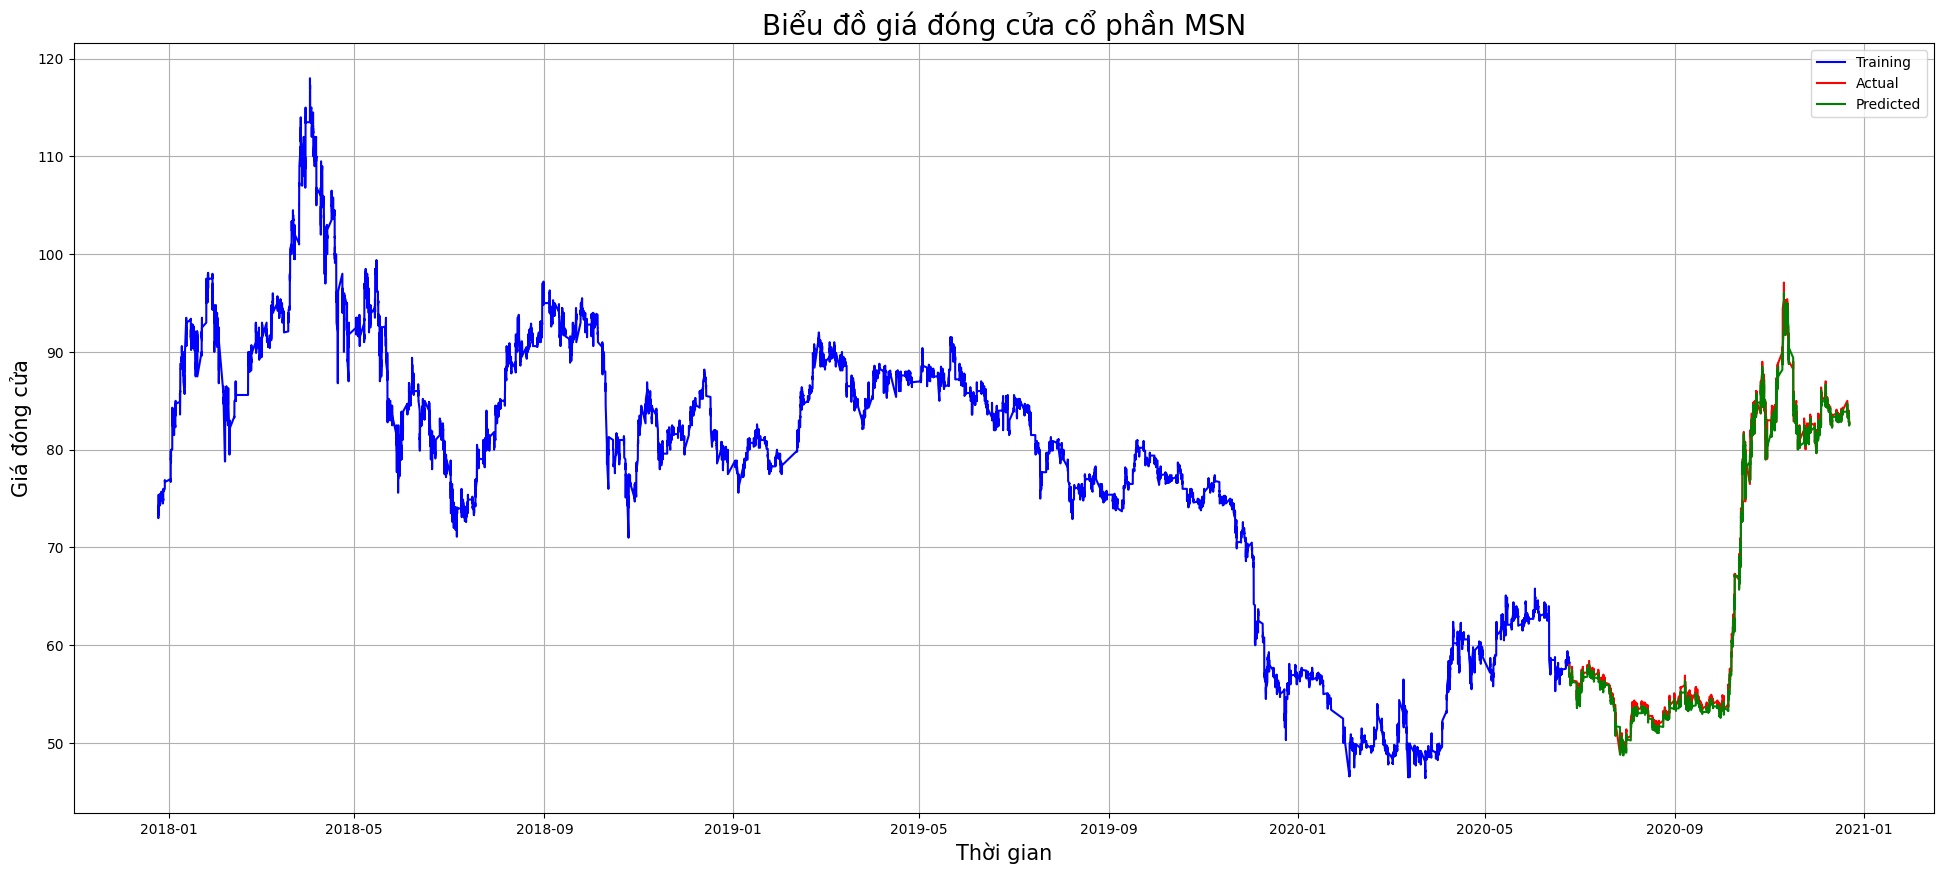

độ phù hợp tập test 0.9992189742147829
sai số tuyệt đối trung bình tập test:  0.3386580331967307
phần trăm sai số truyệt đối trung bình:  0.0055283979951974435
                     Close  Prediction
Date/Time                             
2020-06-24 13:49:00   58.0   57.785355
2020-06-24 13:50:00   58.0   57.747566
2020-06-24 13:52:00   58.0   57.727261
2020-06-24 13:53:00   57.9   57.708416
2020-06-24 13:54:00   57.9   57.651894
...                    ...         ...
2020-12-22 14:23:00   82.8   82.646736
2020-12-22 14:24:00   82.8   82.650848
2020-12-22 14:25:00   82.8   82.652718
2020-12-22 14:27:00   82.8   82.653381
2020-12-22 14:46:00   82.8   82.652962

[27071 rows x 2 columns]


C:\Users\admin\AppData\Local\Temp\ipykernel_19432\4193392405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = pre_closing_price_[i]


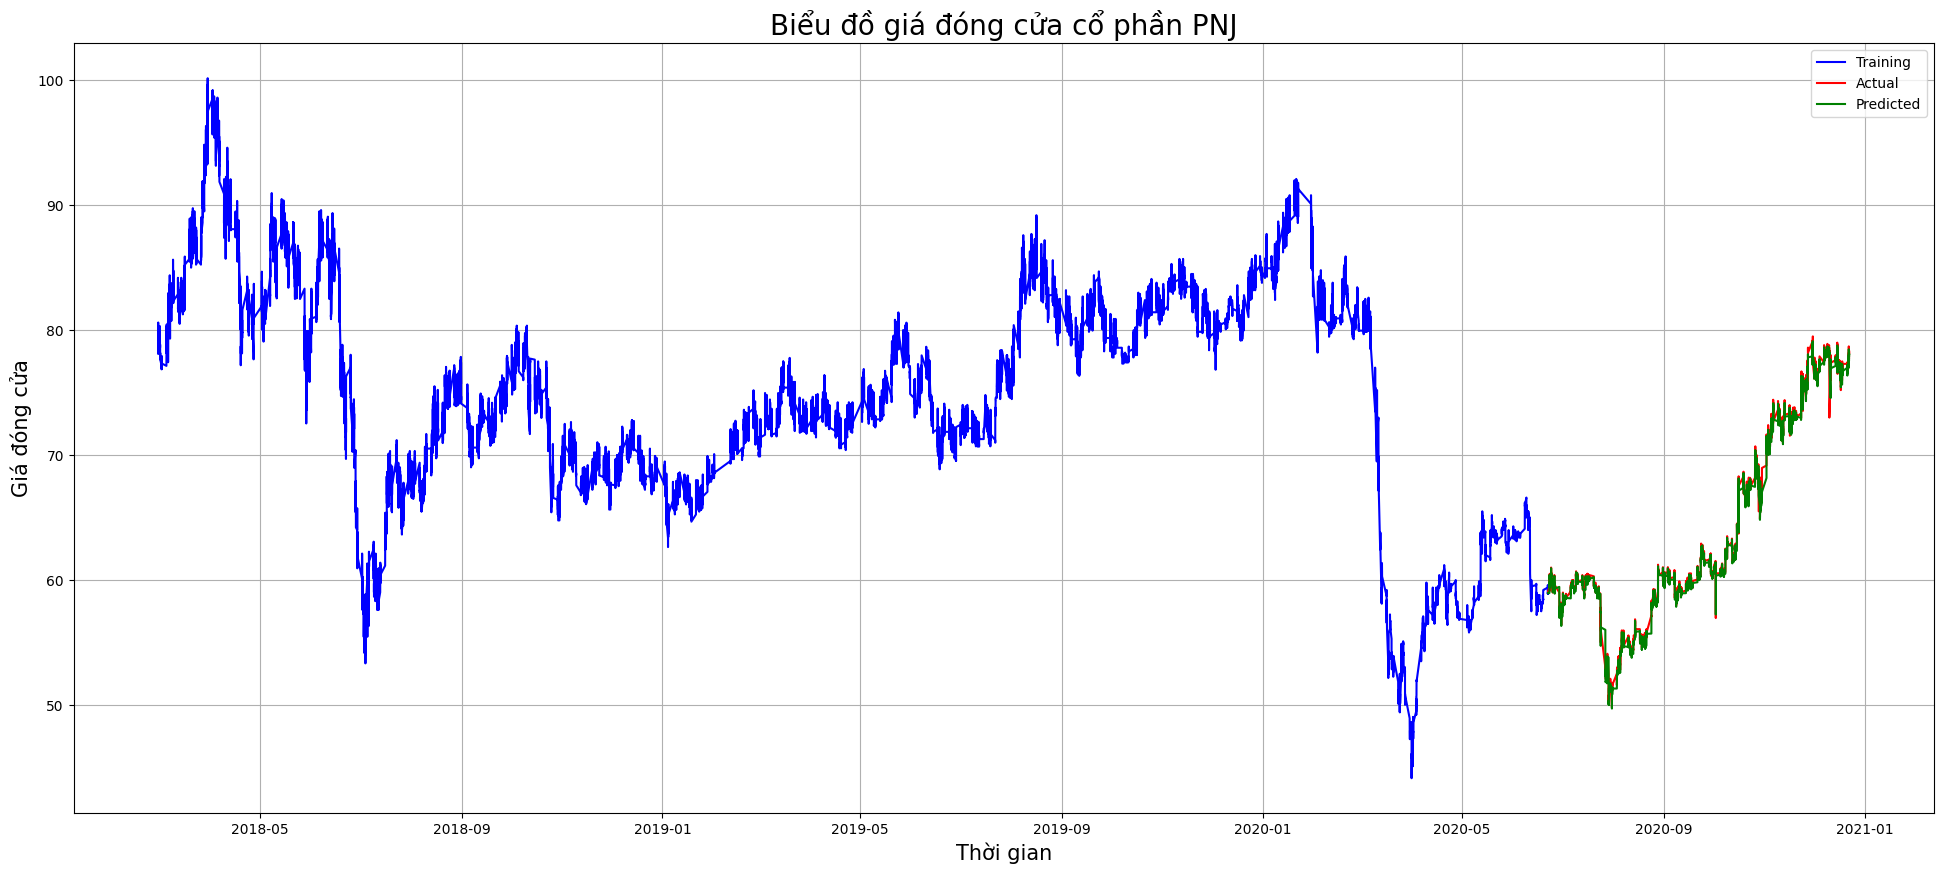

độ phù hợp tập test 0.9993784146182191
sai số tuyệt đối trung bình tập test:  0.14655182285992263
phần trăm sai số truyệt đối trung bình:  0.002297257694445331
                     Close  Prediction
Date/Time                             
2020-06-22 14:28:00   59.0   58.967468
2020-06-22 14:29:00   59.0   58.937977
2020-06-22 14:46:00   59.1   58.924747
2020-06-23 09:15:00   59.5   58.968330
2020-06-23 09:16:00   59.1   59.222225
...                    ...         ...
2020-12-22 14:22:00   78.2   78.111259
2020-12-22 14:23:00   78.2   78.059479
2020-12-22 14:24:00   78.2   78.031700
2020-12-22 14:25:00   78.1   78.021896
2020-12-22 14:46:00   78.3   77.959915

[25062 rows x 2 columns]


C:\Users\admin\AppData\Local\Temp\ipykernel_19432\4193392405.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = pre_closing_price_[i]


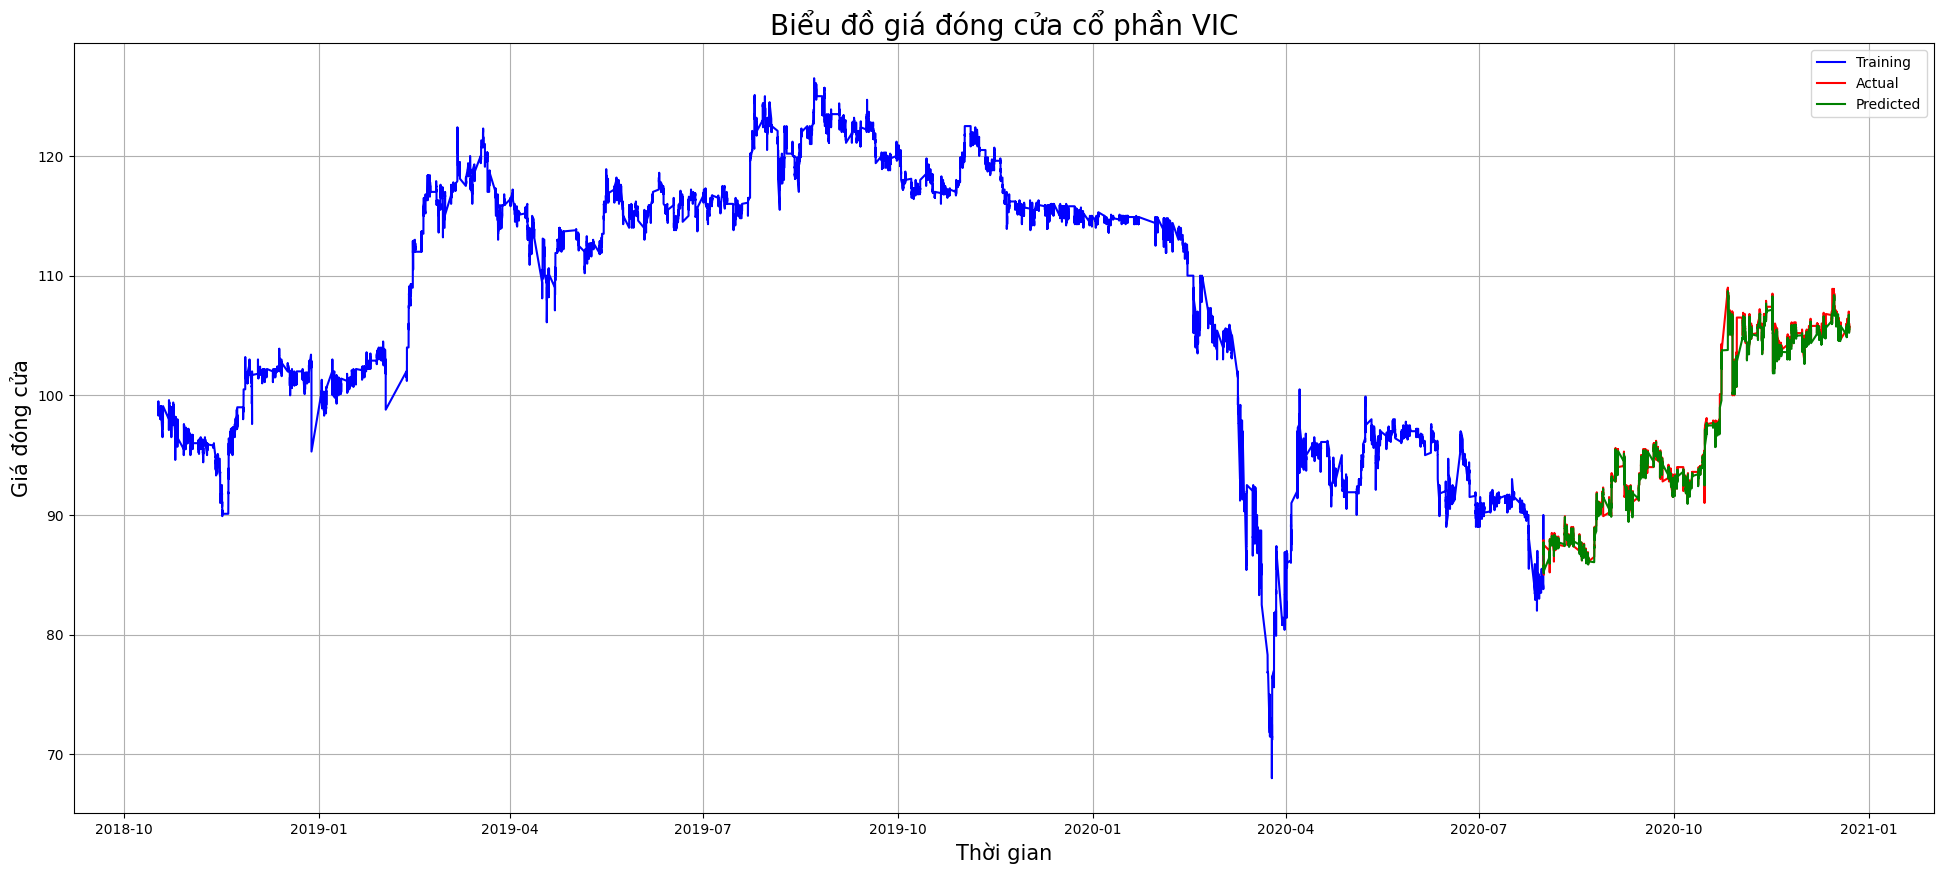

độ phù hợp tập test 0.998868356609157
sai số tuyệt đối trung bình tập test:  0.17341405635550114
phần trăm sai số truyệt đối trung bình:  0.0017563135876512948
                     Close  Prediction
Date/Time                             
2020-07-31 10:08:00   86.8   86.968826
2020-07-31 10:09:00   86.8   86.862740
2020-07-31 10:10:00   86.8   86.802185
2020-07-31 10:11:00   86.8   86.768715
2020-07-31 10:12:00   86.7   86.755394
...                    ...         ...
2020-12-22 14:22:00  105.7  105.604240
2020-12-22 14:23:00  105.7  105.544289
2020-12-22 14:24:00  105.7  105.515602
2020-12-22 14:25:00  105.7  105.507309
2020-12-22 14:46:00  105.7  105.507843

[20254 rows x 2 columns]


In [168]:
for i in stockList: 
    # Plot thông số dự đoán và thực tế
    split = int(0.8*len(data_close_arr_[i]))
    train = data_close_[i][:split]
    test = data_close_[i][split:]
    test['Prediction'] = pre_closing_price_[i]

    plt.figure(figsize=(24,10))
    plt.plot(train['Close'], label='Training', color='blue')
    plt.plot(test['Close'], label='Actual', color='red')
    plt.plot(test['Prediction'], label='Predicted', color='green')
    plt.title("Biểu đồ giá đóng cửa cổ phần " + i, color = 'black', fontsize = 20)
    plt.xlabel('Thời gian', color = 'black', fontsize = 15)
    plt.ylabel('Giá đóng cửa', color = 'black', fontsize = 15)
    plt.legend()
    plt.grid(True)
    plt.show() 

    # kiểm tra độ chính xác của mô hình
    print('độ phù hợp tập test',r2_score(test['Close'],pre_closing_price_[i]))
    print('sai số tuyệt đối trung bình tập test: ',mean_absolute_error(test['Close'],pre_closing_price_[i]))
    print('phần trăm sai số truyệt đối trung bình: ',mean_absolute_percentage_error(test['Close'],pre_closing_price_[i]))
    print(test)

In [169]:
# lưu mô hình
model.save('Model\stock_prediction.h5')

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\admin\AppData\Local\Temp\ipykernel_19432\3942469212.py:1: SyntaxWarning: invalid escape sequence '\s'
  model.save('Model\stock_prediction.h5')
